In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.model_selection import learning_curve, StratifiedKFold
import warnings
# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))


matplotlib: 3.7.0


In [2]:
# Loading data into dataframes
def data_preprocessing(file_name):
    df = pd.read_csv(file_name)
    df.reset_index(drop=True)
    df = df.drop(df.columns[0], axis=1)
    return df

word_embed_train = data_preprocessing('384EMBEDDINGS_TRAIN.csv')
word_embed_test = data_preprocessing('384EMBEDDINGS_TEST.csv')
word_embed_validation = data_preprocessing('384EMBEDDINGS_VALIDATION.csv')

tfidf_train = data_preprocessing('TFIDF_TRAIN.csv')
tfidf_test = data_preprocessing('TFIDF_TEST.csv')
tfidf_validation = data_preprocessing('TFIDF_VALIDATION.csv')

train_data = data_preprocessing('TRAIN.csv')
test_data = data_preprocessing('TEST_NO_LABELS.csv')
validation_data = data_preprocessing('VALIDATION.csv')

In [3]:
# Setting up Train and Test dataset

y_train = train_data['rating'] # Train labels
y_vad = validation_data['rating'] # Validation labels
X_train = train_data.drop('rating', axis=1)
X_vad = validation_data.drop('rating', axis=1)

X_train_embed = word_embed_train # Train features for word embedding
X_vad_embed = word_embed_validation #Validate features

X_train_tf = tfidf_train # Train features for tfidf
X_vad_tf = tfidf_validation # Validate features


In [4]:
# Evaluation
# Get scores for the model
def get_scores(pred_label, true_label, average='macro'):
    # Accuracy
    accuracy = metrics.accuracy_score(true_label, pred_label)
    # Precision, Recall and F1-score (default: macro average)
    score_report = metrics.precision_recall_fscore_support(true_label, pred_label, average=average, zero_division=0) 
    # Confusion Matrix 
    confusion = metrics.confusion_matrix(true_label, pred_label)       
    return accuracy, score_report, confusion 

def plot_cm(plot_name,confusion):
    plt.figure(figsize=(4, 2))
    ax= plt.subplot()
    sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted ratings');ax.set_ylabel('True ratings'); 
    ax.set_title(plot_name); 
    ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

def plot_learning_curve(plot_name, estimator, X_train, y_train, fold=5, scoring='f1_macro'):
    '''
    Stratified K-Folds cross-validator.

Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
    '''
    train_sizes, train_scores, valid_scores = learning_curve(estimator,X_train, 
                                                             y_train, scoring=scoring, cv=StratifiedKFold(fold),
                                                             train_sizes=np.linspace(0.1, 1.0, 5))
    print(f"Train scores: {np.round(np.mean(train_scores, axis=1),4)}")
    print(f"Validation scores: {np.round(np.mean(valid_scores, axis=1),4)}")
    plt.figure(figsize=(4, 3))
    plt.xlabel("training size")
    plt.ylabel("accuracy")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0,1.1,step=0.1))
    plt.grid(visible=True)
    plt.title(plot_name)
    plt.legend(loc="best")
    plt.show()

def display_performance(plot_name, pred_label, true_label):
    accuracy, scores, cm = get_scores(pred_label, true_label)
    print("Accuracy: ", round(accuracy,4))
    print("Precision: ", round(scores[0],4))
    print("Recall: ", round(scores[1],4))
    print("F1 : ", round(scores[2],4))
    plot_cm(plot_name, cm)

Accuracy:  0.7342
Precision:  0.3671
Recall:  0.5
F1 :  0.4234
Train scores: [0.4139 0.4153 0.4169 0.4181 0.4179]
Validation scores: [0.4179 0.4179 0.4179 0.4179 0.4179]


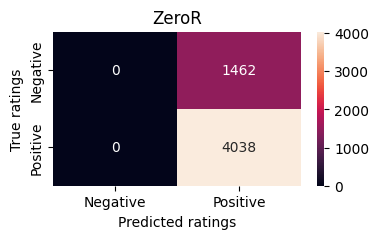

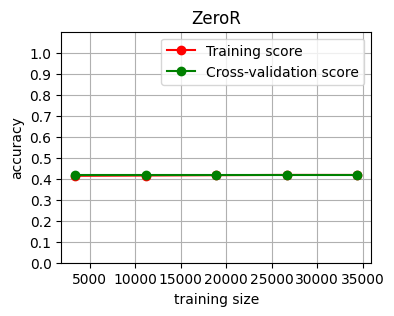

In [5]:
# Baseline Model by Majority Vote #
# Given the dataset is skewed, it's makes sense to use majority vote to establish the baseline
plot_name = "ZeroR"
def majority_vote(X_train, X_test, y_train):
    estimator = DummyClassifier(strategy='most_frequent')
    estimator.fit(X=X_train, y=y_train)
    pred = estimator.predict(X=X_test)
    return pred, estimator

# Word-embedding
mv_pred, mv_estimator = majority_vote(X_train, X_vad, y_train)
display_performance(plot_name,mv_pred, y_vad)
plot_learning_curve(plot_name,mv_estimator, X_train, y_train)

In [3]:
# Given train and validation scores
train_scores = np.array([0.4139, 0.4153, 0.4169, 0.4181, 0.4179])
validation_scores = np.array([0.4179, 0.4179, 0.4179, 0.4179, 0.4179])

# Calculate the mean for train and validation scores
mean_train_score = np.mean(train_scores)
mean_validation_score = np.mean(validation_scores)

# Calculate the difference between the means
mean_difference = mean_train_score - mean_validation_score

mean_train_score, mean_validation_score, mean_difference


(0.41642, 0.41790000000000005, -0.0014800000000000368)